In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from zipfile import ZipFile

sys.path.append("D:/EPFL/Master_thesis/server/nokki_openbar/plbox/") 
# D:\EPFL\Master_thesis\server\nokki_openbar\plbox

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from plbox.decomposition.autoencode.utils import *
from plbox.decomposition.autoencode.autoencode import *
from plbox.decomposition.autoencode.dbscan_latent import *
import gc
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 


Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


In [3]:
train_df.feature_0 = train_df.feature_0.astype(np.int8)
train_df.date= train_df.date.astype(np.int16)
train_df.ts_id = train_df.ts_id.astype(np.int32)
for i in train_df:
    if train_df[i].dtype == np.float64:
        if (((train_df[i] < .0001) & (train_df[i] > -.0001)).mean()) < .001:
            train_df[i] = train_df[i].astype(np.float32)
            gc.collect();
            
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.3 GB


In [4]:
#sort by date and ts_id
train_df.sort_values(by= ['date','ts_id'],inplace=True)
train_df['action'] = np.where(train_df['resp'] > 0,1,0)
train_df.action = train_df.action.astype(np.int8)
train_df

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,1.168391,8.313582,1.782433,14.018213,2.653056,12.600291,2.301488,11.445807,0,1
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,-1.178850,1.777472,-0.915459,2.831612,-1.417010,2.297459,-1.304614,1.898684,1,0
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2,1
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174379,0.344640,...,2.838853,0.499251,3.033731,1.513488,4.397532,1.266037,3.856384,1.013469,3,0
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390486,499,0.000000,0.000142,0.000142,0.005829,0.020342,0.015396,1,-1.649365,-1.169997,...,-1.260055,1.947725,-1.994399,-1.685163,-2.866165,-0.216130,-1.892048,0.901585,2390486,1
2390487,499,0.000000,0.000012,0.000012,-0.000935,-0.006326,-0.004718,1,2.432943,5.284504,...,1.064936,3.119762,-0.419796,-0.208975,-0.146749,0.730166,0.648452,2.068737,2390487,0
2390488,499,0.000000,0.000499,0.000499,0.007605,0.024907,0.016591,1,-0.622475,-0.963682,...,-0.640334,-2.279663,-0.950259,-4.388417,-1.669922,-3.288939,-1.336142,-2.814239,2390488,1
2390489,499,0.283405,-0.000156,-0.000156,-0.001375,-0.003702,-0.002004,-1,-1.463757,-1.107228,...,-1.780962,0.881246,-2.202140,-1.912601,-3.341684,-0.571187,-2.185795,0.627452,2390489,0


In [5]:
y = train_df['action']

X = train_df.copy()
X.drop(columns=['action'], inplace=True)

#feature Engineering
X = X.loc[:, X.columns.str.contains('feature')]
f_median = X.median()
X.fillna(f_median, inplace=True) #fill na values with feature median

# creating one hot encoder object with categorical feature 0 
columnTransformer = ColumnTransformer([('encoder', 
                                        OneHotEncoder(), 
                                        ['feature_0'])], 
                                      remainder='passthrough') 
  
X = pd.DataFrame(columnTransformer.fit_transform(X), index=X.index) 


#split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)


#split into train and valid


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=False)



   



In [6]:
model = AE_Explanation(epochs=100, early_stop_pat=30, lr_reduce_pat=10, l1_reg=1.5e-6,
                       architecture=[100, 86, 74, 64, 54, 44, 32], loss='Huber', match_pred_activation='sigmoid',
                       match_pred_loss='binary_crossentropy')




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 131)          0                                            
__________________________________________________________________________________________________
encoder1 (Dense)                (None, 100)          13200       input_1[0][0]                    
__________________________________________________________________________________________________
encoder2 (Dense)                (None, 86)           8686        encoder1[0][0]                   
__________________________________________________________________________________________________
encoder3 (Dense)                (None, 74)           6438        encoder2[0][0]                   
__________________________________________________________________________________________________
encoder

1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6937 - reconstructued_loss: 2.5667e-05 - match_pred_loss: 0.6918 - val_loss: 0.6947 - val_reconstructued_loss: 7.4549e-05 - val_match_pred_loss: 0.6930
Epoch 7/100
1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6931 - reconstructued_loss: 5.3376e-05 - match_pred_loss: 0.6917 - val_loss: 0.6944 - val_reconstructued_loss: 1.9840e-04 - val_match_pred_loss: 0.6929
Epoch 8/100
1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6928 - reconstructued_loss: 1.1517e-04 - match_pred_loss: 0.6915 - val_loss: 0.6940 - val_reconstructued_loss: 3.6267e-05 - val_match_pred_loss: 0.6929
Epoch 9/100
1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6924 - reconstructued_loss: 1.2128e-05 - match_pred_loss: 0.6914 - val_loss: 0.6938 - val_reconstructued_loss: 3.7494e-05 - val_match_pred_loss: 0.6928
Epoch 10/100
1625533/1625533 [==========================

1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6896 - reconstructued_loss: 1.1042e-05 - match_pred_loss: 0.6888 - val_loss: 0.6942 - val_reconstructued_loss: 7.3923e-06 - val_match_pred_loss: 0.6934
Epoch 40/100
1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6895 - reconstructued_loss: 9.1056e-06 - match_pred_loss: 0.6887 - val_loss: 0.6942 - val_reconstructued_loss: 3.7607e-06 - val_match_pred_loss: 0.6934
Epoch 41/100
1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6894 - reconstructued_loss: 6.6376e-06 - match_pred_loss: 0.6887 - val_loss: 0.6942 - val_reconstructued_loss: 4.5259e-06 - val_match_pred_loss: 0.6935
Epoch 42/100
1625533/1625533 [==============================] - 23s 14us/step - loss: 0.6894 - reconstructued_loss: 6.9149e-06 - match_pred_loss: 0.6886 - val_loss: 0.6943 - val_reconstructued_loss: 3.8646e-06 - val_match_pred_loss: 0.6935
Epoch 43/100
1625533/1625533 [=======================

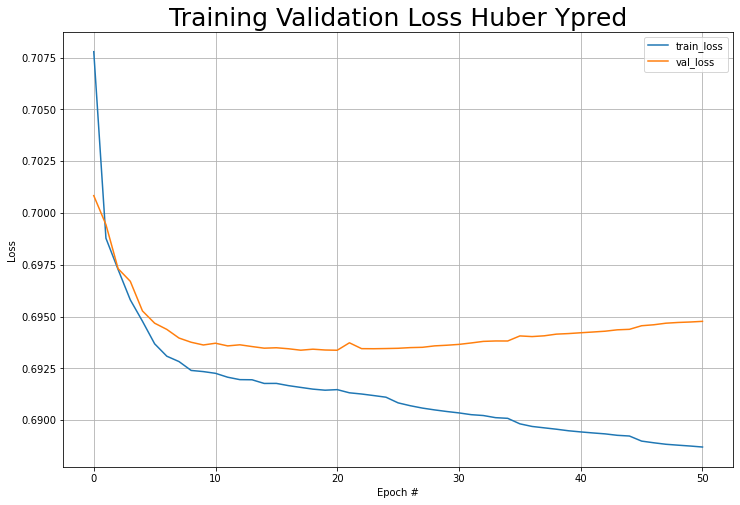





###################### Freezing encoder and retraining decoder, trainable layers: 
<keras.layers.core.Dense object at 0x0000020AB042A7B8> decoder1
<keras.layers.core.Dense object at 0x0000020AB044F978> decoder2
<keras.layers.core.Dense object at 0x0000020AB0418B38> decoder3
<keras.layers.core.Dense object at 0x0000020AB041DC50> decoder4
<keras.layers.core.Dense object at 0x0000020AB042DE10> decoder5
<keras.layers.core.Dense object at 0x0000020AB04610B8> decoder6
<keras.layers.core.Dense object at 0x0000020AB0452278> reconstructued
<keras.layers.core.Reshape object at 0x0000020AB23F15F8> reshape_1
Train on 1625533 samples, validate on 406384 samples
Epoch 1/100
1625533/1625533 [==============================] - 19s 11us/step - loss: 0.8848 - reshape_1_loss: 0.1964 - match_pred_loss: 0.6876 - val_loss: 0.8802 - val_reshape_1_loss: 0.1854 - val_match_pred_loss: 0.6940
Epoch 2/100
1625533/1625533 [==============================] - 18s 11us/step - loss: 0.8820 - reshape_1_loss: 0.1936 -

Epoch 35/100
1625533/1625533 [==============================] - 18s 11us/step - loss: 0.8776 - reshape_1_loss: 0.1892 - match_pred_loss: 0.6876 - val_loss: 0.8750 - val_reshape_1_loss: 0.1802 - val_match_pred_loss: 0.6940
Epoch 36/100
1625533/1625533 [==============================] - 18s 11us/step - loss: 0.8776 - reshape_1_loss: 0.1892 - match_pred_loss: 0.6876 - val_loss: 0.8750 - val_reshape_1_loss: 0.1802 - val_match_pred_loss: 0.6940
Epoch 37/100
1625533/1625533 [==============================] - 18s 11us/step - loss: 0.8776 - reshape_1_loss: 0.1892 - match_pred_loss: 0.6876 - val_loss: 0.8750 - val_reshape_1_loss: 0.1802 - val_match_pred_loss: 0.6940
Epoch 38/100
1625533/1625533 [==============================] - 18s 11us/step - loss: 0.8776 - reshape_1_loss: 0.1892 - match_pred_loss: 0.6876 - val_loss: 0.8750 - val_reshape_1_loss: 0.1802 - val_match_pred_loss: 0.6940
Epoch 39/100
1625533/1625533 [==============================] - 18s 11us/step - loss: 0.8776 - reshape_1_loss: 0

1625533/1625533 [==============================] - 21s 13us/step - loss: 0.8775 - reshape_1_loss: 0.1891 - match_pred_loss: 0.6876 - val_loss: 0.8747 - val_reshape_1_loss: 0.1799 - val_match_pred_loss: 0.6940
Epoch 72/100
1625533/1625533 [==============================] - 20s 12us/step - loss: 0.8775 - reshape_1_loss: 0.1891 - match_pred_loss: 0.6876 - val_loss: 0.8747 - val_reshape_1_loss: 0.1799 - val_match_pred_loss: 0.6940
Epoch 73/100
1625533/1625533 [==============================] - 19s 12us/step - loss: 0.8775 - reshape_1_loss: 0.1891 - match_pred_loss: 0.6876 - val_loss: 0.8747 - val_reshape_1_loss: 0.1799 - val_match_pred_loss: 0.6940

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.
Epoch 74/100
1625533/1625533 [==============================] - 19s 12us/step - loss: 0.8776 - reshape_1_loss: 0.1893 - match_pred_loss: 0.6876 - val_loss: 0.8746 - val_reshape_1_loss: 0.1798 - val_match_pred_loss: 0.6940
Epoch 75/100
1625533/1625533 [=============

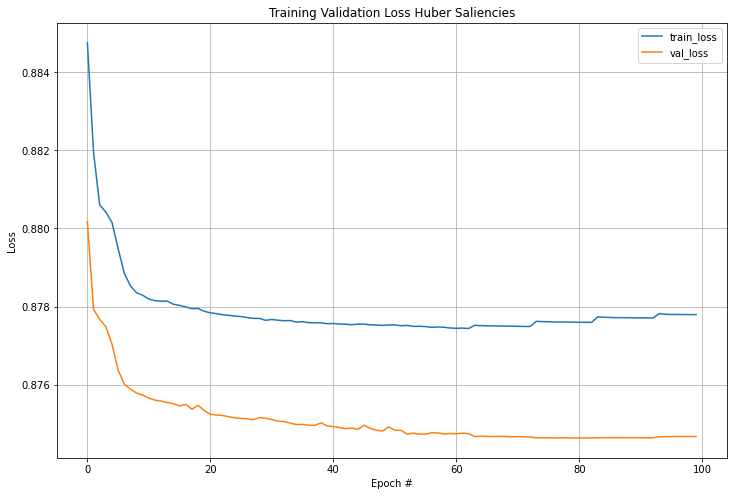

AE_Explanation(architecture=[100, 86, 74, 64, 54, 44, 32], dropout=0.0,
               early_stop_pat=30, epochs=100, l1_reg=1.5e-06, loss='Huber',
               lr_optimizer=0.001, lr_reduce_pat=10,
               match_pred_activation='sigmoid',
               match_pred_loss='binary_crossentropy', noise=0.0,
               optimizer='Adam', seed=None, to_clip=False)

In [7]:
model.fit(X_train, y_train, X_val, y_val, plots=True)

In [8]:
y_predicted = model.predict_(X_test)[1]

In [9]:
roc_auc_score(y_test, y_predicted)

0.5302926099631187

In [10]:
to_submit_df = pd.read_csv('./data/example_test.csv')
to_submit_df = to_submit_df[to_submit_df['weight']>0]
to_submit_df.reset_index(drop=True, inplace=True)
to_submit_df = to_submit_df.loc[:, to_submit_df.columns.str.contains('feature')].copy()
to_submit_df.fillna(f_median, inplace=True) #fill na values with feature median
to_submit_df = pd.DataFrame(columnTransformer.transform(to_submit_df), index=to_submit_df.index) 
to_submit_df

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,1.0,0.0,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,0.000000,0.000000,...,0.000000,0.000000,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684
1,0.0,1.0,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,0.000000,0.000000,...,0.000000,0.000000,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633
2,1.0,0.0,-3.172026,-3.093182,-0.030588,-0.043175,0.097058,0.053483,0.000000,0.000000,...,0.000000,0.000000,0.336873,4.076447,0.614783,6.622176,0.800618,5.231595,0.361506,3.921714
3,1.0,0.0,0.446050,-0.466210,0.498751,0.244116,0.412528,0.224140,0.000000,0.000000,...,0.000000,0.000000,2.101997,4.846202,1.479875,5.261328,2.305066,4.571762,2.201537,4.429745
4,0.0,1.0,-3.172026,-3.093182,-0.363836,-0.291496,0.128422,0.096168,0.000000,0.000000,...,0.000000,0.000000,1.537913,4.785838,1.637435,6.968002,2.354338,5.825499,1.778029,4.740577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772,1.0,0.0,-3.172026,-3.093182,3.098586,2.397642,1.995557,1.499154,0.772727,0.532238,...,-0.710321,-0.203645,0.703743,3.189302,-0.532226,0.183257,-0.048928,1.635185,0.699063,2.904913
11773,0.0,1.0,-1.811504,-2.306446,3.917303,2.495504,1.390398,0.762097,2.701736,1.994287,...,1.452227,-1.938755,3.743729,0.754253,1.499055,-1.817823,2.469732,-1.051702,2.867944,-0.301983
11774,1.0,0.0,0.766996,0.397504,3.884914,3.558184,3.226635,2.914808,-0.206605,-0.295693,...,0.101602,-0.369151,1.151413,1.301698,-0.061946,-1.062610,0.575003,0.261161,1.205862,1.145315
11775,1.0,0.0,11.429610,7.072927,-6.714210,-4.166545,-3.980052,-2.372645,-2.357589,-1.825029,...,1.872610,-1.588960,3.297573,0.167565,1.284142,-2.451120,2.631636,-1.133878,3.054784,-0.360152


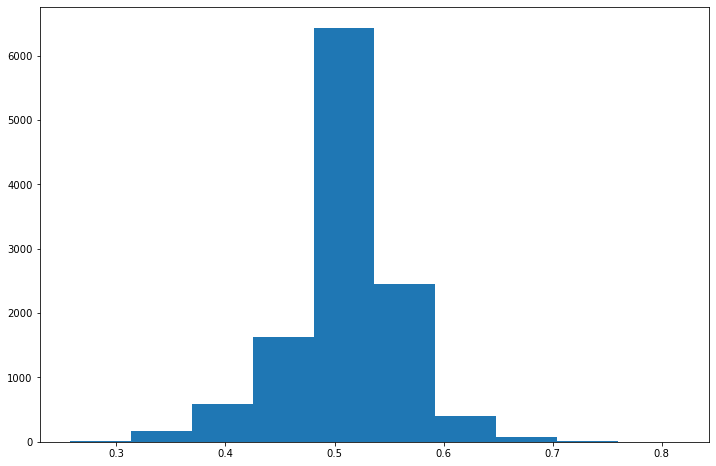

In [11]:
y_to_submit = model.predict_(to_submit_df)[1]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.hist(y_to_submit);

In [12]:
np.savetxt("jane_street_predictions.csv", y_to_submit, delimiter=",")

In [13]:
model.save("./weights_model/")